In [13]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from tqdm.auto import tqdm
from tqdm import tqdm
import torch

# we dont need gradient!
torch.no_grad()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [14]:
student_id=21522188

In [15]:
def initialize_population(num_individuals, num_variables):
    """
    Khởi tạo quần thể gồm num_individuals cá thể. Mỗi cá thể có num_parameters biến.

    Arguments:
    num_individuals -- Số lượng cá thể
    num_variables -- Số lượng biến

    Returns:
    pop -- Ma trận (num_individuals, num_variables ) chứa quần thể mới được khởi tạo ngẫu nhiên.
    """

    pop = torch.randint(0, 2, (num_individuals, num_variables), device=device)

    return pop


# optimized for multithreading


def crossover(pop):
    """
    Hàm biến đổi tạo ra các cá thể con.

    Arguments:
    pop -- Quàn thể hiện tại.

    Returns:
    offspring -- Quần thể chứa các cá thể con được sinh ra.
    """

    num_individuals, num_parameters = pop.shape
    # Đảo ngẫu nhiên thứ tự các cá thể trong quần thể
    indexes = torch.randperm(num_individuals, device=device)
    # (num_individuals, num_parameters)
    pop = pop[indexes]

    if num_individuals % 2 != 0:
        pop = pop[:-1]
        num_individuals -= 1

    num_pairs = num_individuals // 2

    # i.e.
    # pop1      [0, 1, 2, 3,   4, 5, 6, 7]
    # pop2      [4, 5, 6, 7,   0, 1, 2, 3]

    # t         [0, 1, 2, 3,   0, 1, 2, 3]

    # (num_individuals * num_parameters)
    pop1 = pop.reshape(-1)
    pop2 = pop.reshape((2, num_pairs, num_parameters)).flip(0).reshape((-1))

    t = (
        torch.rand(num_pairs * num_parameters, device=device)
        .unsqueeze(0)
        .expand((2, num_pairs * num_parameters))
        .reshape((-1))
    )

    # (num_offsprings * num_parameters)
    offsprings = torch.where(t < 0.5, pop1, pop2)

    return offsprings.reshape((num_individuals, num_parameters))


def mutation(pop, mutation_prob):

    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # (num_individuals * num_parameters)
    pop = pop.reshape((-1))

    t = torch.rand(num_individuals * num_parameters, device=device)

    # flip bit with a probability of mutation_prob
    res = torch.where(t < mutation_prob, 1 - pop, pop)

    res = res.reshape((num_individuals, num_parameters))

    return res

# Benchmark functions

In [16]:
def onemax(pop):
    # pop (num_individuals, num_parameters)
    return torch.sum(pop, dim=-1)

def leadingone(pop):
    first_items = pop[:,0]
    # indice of the first 0
    first_idx = torch.argmin(pop, dim=-1)
    return torch.where(first_idx==0, first_items*(pop.shape[1]), first_idx)

def trap(pop, nof_bits=5):
    # assume num_parameters is divisible by nof_bits

    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    # (num_individuals, num_parameters//nof_bits )
    t = pop.reshape((num_individuals, -1, nof_bits)).sum(axis=-1)

    # (num_individuals, num_parameters//nof_bits )
    values = torch.where(t < nof_bits, nof_bits - 1 - t, nof_bits)

    # (num_individuals )
    return values.sum(dim=-1)


objective_funcs = {
    "Onemax": onemax,
    "LeadingOne": leadingone,
    "Concatenated Trap-5": trap,
}

In [17]:
t = torch.tensor([
    [1,1,1,1,1],
    [1,1,1,1,0],
])
print("onemax", onemax(t))
print("leadingone", leadingone(t))
print("trap", trap(t))

onemax tensor([5, 4])
leadingone tensor([5, 4])
trap tensor([5, 0])


# Selection functions

In [18]:
def truncation_selection(pop, pop_fitness, selection_size):
    return torch.topk(pop_fitness, k=selection_size, sorted=False).indices

def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    # pop (num_individuals, num_parameters)
    num_individuals, num_parameters = pop.shape

    uniform_dis = torch.ones((selection_size, num_individuals), device=device)
    # select tournament_size opponents from the population selection_size times
    # (selection_size * tournament_size)
    t_indices = uniform_dis.multinomial(
        num_samples=tournament_size,
        replacement=False
    ).flatten()

    # fitness of each opponent
    # (selection_size * tournament_size)
    t_fitness = pop_fitness[t_indices]

    # (selection_size, tournament_size)
    t_fitness = t_fitness.reshape((selection_size, tournament_size))

    # winner of each tournament
    # (selection_size)
    t_winners = torch.argmax(t_fitness, dim=1)
    
    # convert to the actual indices of t_indices
    t_winners = t_winners + torch.arange(selection_size, device=device) * tournament_size

    return t_indices[t_winners]


def proportional_selection(pop, pop_fitness, selection_size):
    return torch.multinomial(pop_fitness.float(), selection_size, replacement=True)


selection_funcs = {
    "tournament": tournament_selection,
    "truncation": truncation_selection,
    "proportional": proportional_selection,
}

# Genetic algorithm

In [19]:
def genetic_algorithm(
    objective=onemax,
    selection_func=truncation_selection,
    num_individuals=32,
    num_parameters=100,
    max_evaluations=100000,
    use_mutation=False,
    seed=49,
):
    # seeding
    torch.manual_seed(seed)

    # (P)
    pop = initialize_population(num_individuals, num_parameters)
    
    pop_fitness = objective(pop)

    num_evaluations = num_individuals
    best_fitness = []

    selection_size = num_individuals

    while num_evaluations < max_evaluations:
        best_fitness.append([num_evaluations, pop_fitness.max().cpu().numpy()])

        # (O)
        offspring = crossover(pop)
        # no mutation
        if use_mutation:
            offspring = mutation(offspring, 0.1)

        offspring_fitness = objective(offspring)
        num_evaluations += len(offspring)

        # (P+O)
        pop_off = torch.vstack([pop, offspring])
        pop_off_fitness = torch.concatenate((pop_fitness, offspring_fitness))

        # tournament selection will have a constant tournament_size of 4
        # select N individuals from (P+O) 2N
        # selected_indices is not sorted by fitness
        selected_indices = selection_func(pop_off, pop_off_fitness, selection_size)

        pop = pop_off[selected_indices]
        pop_fitness = pop_off_fitness[selected_indices]


    best_fitness.append([num_evaluations, pop_fitness.max().cpu().numpy()])

    return (pop, pop_fitness, best_fitness)



def benchmark(
    objective_func="Onemax",
    selection_func="truncation",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=8,
    init_seed=student_id,
    use_mutation=False
):
    assert objective_func in objective_funcs.keys()
    assert selection_func in selection_funcs.keys()

    res = [
        genetic_algorithm(
            objective=objective_funcs[objective_func],
            selection_func=selection_funcs[selection_func],
            num_individuals=num_individuals,
            num_parameters=num_parameters,
            max_evaluations=max_evaluations,
            seed=init_seed+i,
            use_mutation=use_mutation
        )
        for i in tqdm(range(n_trials))
    ]

    fits = []
    evals = []


    for i, (pop, pop_fitness, best_fitness) in enumerate(res):
        best_fitness = np.array(best_fitness)
        if i == 0:
            evals = best_fitness[:,0]
        fits.append(best_fitness[:,1])
    
    fits = np.array(fits)

    avg = np.mean(fits, axis=0)
    err = np.std(fits, axis=0)

    return evals, avg, err

# Results

In [20]:
def test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=128,
    use_mutation=False,
    init_seed=student_id,
    axes=None,
    ):
    for s in selection_funcs.keys():
        print(objective_func, "-", s)
        evals, avg, err = benchmark(
            objective_func=objective_func,
            selection_func=s,
            n_trials=n_trials,
            num_parameters=num_parameters,
            max_evaluations=max_evaluations,
            num_individuals=num_individuals,
            init_seed=student_id,
            use_mutation=use_mutation
        )
        axes.plot(evals, avg, label=s)
        axes.fill_between(evals, avg+err, avg-err, alpha=0.1)

    axes.set_xlabel("Evaluations")
    axes.set_ylabel("Fitness")

    axes.set_xlim(0, max_evaluations+num_individuals)
    axes.set_title(f"{objective_func} on {num_parameters} Dimensions with {num_individuals} population size")
    axes.legend();

In [21]:
print(selection_funcs.keys())
print(objective_funcs.keys())

dict_keys(['tournament', 'truncation', 'proportional'])
dict_keys(['Onemax', 'LeadingOne', 'Concatenated Trap-5'])


Onemax - tournament


100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Onemax - truncation


100%|██████████| 10/10 [00:00<00:00, 16.96it/s]


Onemax - proportional


100%|██████████| 10/10 [00:00<00:00, 14.65it/s]


LeadingOne - tournament


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


LeadingOne - truncation


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


LeadingOne - proportional


100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Concatenated Trap-5 - tournament


100%|██████████| 10/10 [00:02<00:00,  4.98it/s]


Concatenated Trap-5 - truncation


100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


Concatenated Trap-5 - proportional


100%|██████████| 10/10 [00:00<00:00, 13.21it/s]


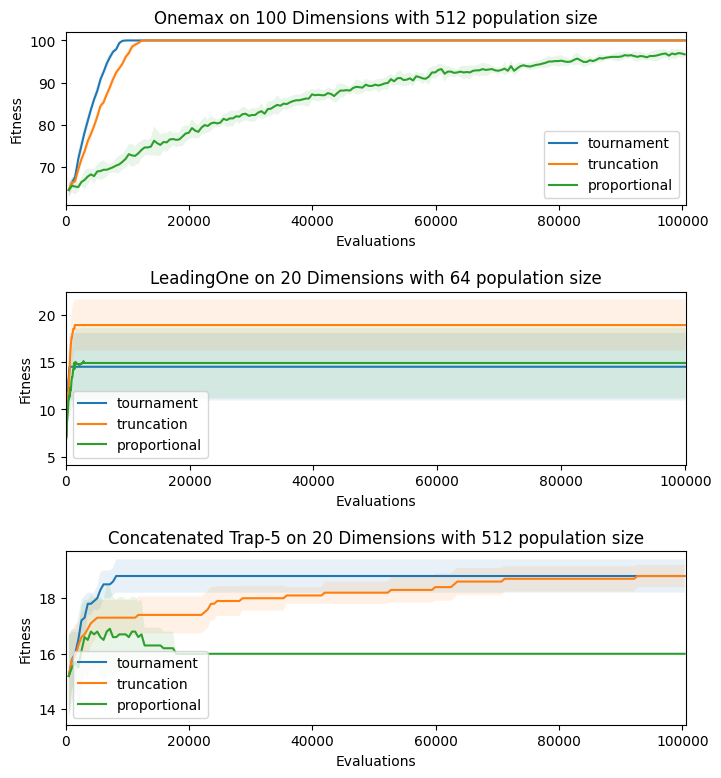

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.5)
test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=512,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[0],
)
test(
    objective_func="LeadingOne",
    n_trials=10,
    num_parameters=20,
    max_evaluations=100000,
    num_individuals=64,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[1],
)

test(
    objective_func="Concatenated Trap-5",
    n_trials=10,
    num_parameters=20,
    max_evaluations=100000,
    num_individuals=512,
    use_mutation=False,
    init_seed=student_id,
    axes=ax[2],
)

# Nhận xét
* proportionl selection không tăng đều như hai hàm selection còn lại có thể vì yếu tố ngẫu nhiên trong phép selection.
* tournament selection dù chọn tournament một cách ngẫu nhiên như proportionl selection nhưng tăng nhanh hơn truncation: một hàm luôn chọn các cá thể tốt nhất.
* Concatenated Trap-5 sẽ trở nên khó hơn khi mutation được áp dụng dẫn đến việc hình thành các chuỗi chỉ gồm các số 1 khó hơn.
* tournament selection cho ra kết quả tốt hơn trong onemax và Concatenated Trap-5 nhưng lại không thể giải được hàm leadingone.

* cuda chỉ tính toán nhanh hơn khi num_parameters và num_individuals lớn.

# Bonus

Onemax - tournament


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Onemax - truncation


100%|██████████| 10/10 [00:00<00:00, 15.31it/s]


Onemax - proportional


100%|██████████| 10/10 [00:00<00:00, 13.70it/s]


LeadingOne - tournament


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


LeadingOne - truncation


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


LeadingOne - proportional


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Concatenated Trap-5 - tournament


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


Concatenated Trap-5 - truncation


100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


Concatenated Trap-5 - proportional


100%|██████████| 10/10 [00:00<00:00, 10.68it/s]


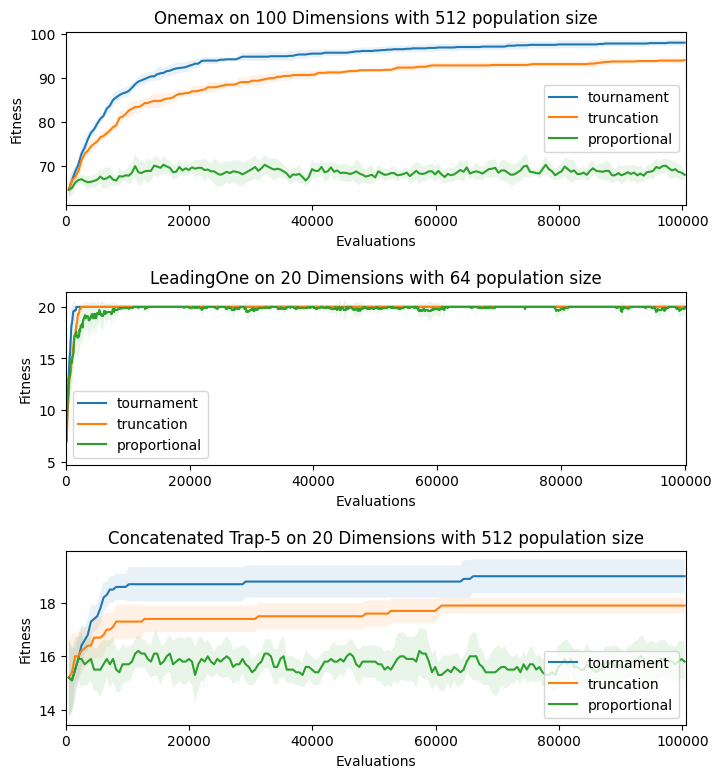

In [23]:
# với mutation thì tournament đạt kết quả tốt hơn trong leadingone nhưng tệ hơn trong các hàm còn lại
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.5)
test(
    objective_func="Onemax",
    n_trials=10,
    num_parameters=100,
    max_evaluations=100000,
    num_individuals=512,
    use_mutation=True,
    init_seed=student_id,
    axes=ax[0],
)
test(
    objective_func="LeadingOne",
    n_trials=10,
    num_parameters=20,
    max_evaluations=100000,
    num_individuals=64,
    use_mutation=True,
    init_seed=student_id,
    axes=ax[1],
)

test(
    objective_func="Concatenated Trap-5",
    n_trials=10,
    num_parameters=20,
    max_evaluations=100000,
    num_individuals=512,
    use_mutation=True,
    init_seed=student_id,
    axes=ax[2],
)

Concatenated Trap-5 - tournament


100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


Concatenated Trap-5 - truncation


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Concatenated Trap-5 - proportional


100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


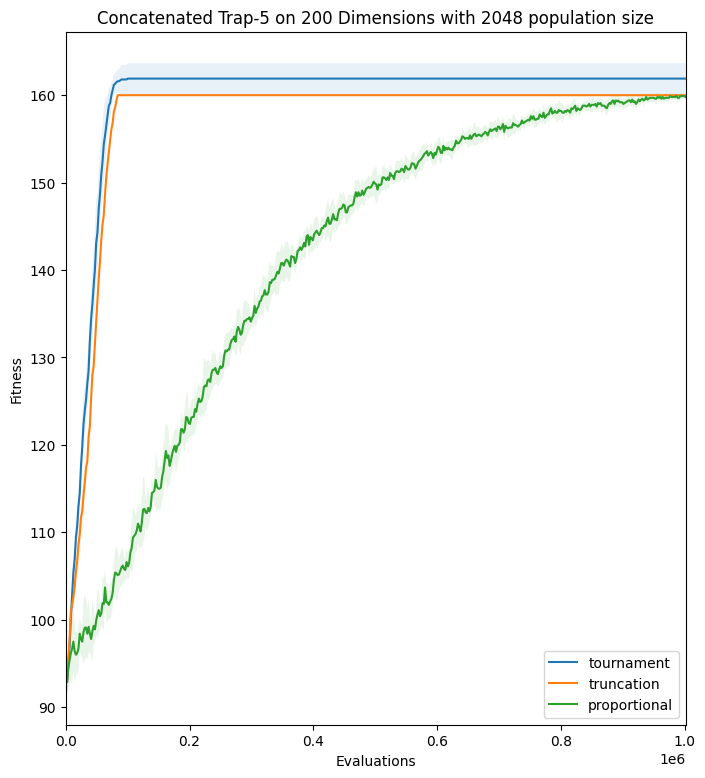

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 9))
plt.subplots_adjust(hspace=0.5)
# cuda sẽ xử lý nhanh hơn khi các ma trận có kích thức lớn.
test(
    objective_func="Concatenated Trap-5",
    n_trials=10,
    num_parameters=200,
    max_evaluations=1000000,
    num_individuals=1024*2,
    use_mutation=False,
    init_seed=student_id,
    axes=ax,
)